# Hate Speech and Offensive Language Detection 

![Hate Speech Detection](https://storage.googleapis.com/kaggle-datasets-images/723100/1257215/78b5d353029eb9d0b504f38f7163a057/dataset-cover.jpg?t=2020-06-17-19-26-39)

## Introduction

The detection of hate speech and offensive language is a crucial task within the realm of natural language processing (NLP) and machine learning. This involves identifying and categorizing text that may contain hate speech, offensive language, or other toxic communications. Given the exponential growth of user-generated content across the web, automated tools for detecting such language are vital for maintaining respectful and safe online communities.

## Importance of Detection

- **Promoting Online Safety**: Essential for creating safer online environments by filtering out content that could lead to emotional distress or real-world harm.
- **Ensuring Legal Compliance**: With increasing regulations against hate speech and offensive content, it's important for platforms to monitor and manage such content.
- **Upholding Community Standards**: Social media platforms and online forums strive to maintain community guidelines, necessitating the moderation of hate speech and offensive language.

## Applications

- **Social Media Platforms**: To monitor user-generated content, ensuring it adheres to the platform's policies.
- **Online Forums and Comments Sections**: For automatic identification and moderation of inappropriate content to foster constructive discussions.
- **Content Moderation Systems**: Employed by various organizations to automatically screen and control the content.

## Examples

Hate speech and offensive language can manifest in various forms, including but not limited to:

- Statements inciting violence against specific groups based on race, religion, gender, etc.
- Use of derogatory terms or slurs aimed at demeaning a particular group.
- Content spreading harmful stereotypes intended to provoke hatred.

**Disclaimer**: The examples provided are for illustrative purposes and reflect the types of content these detection systems aim to identify.

## Dataset Overview

The dataset used in this project comprises 24,783 entries, annotated for hate speech, offensive language, or neither, making it an invaluable resource for training our detection model. Here's a brief overview:

- **Entries**: 24,783 social media posts and comments.
- **Columns**: Includes metrics such as `hate_speech`, `offensive_language`, and `neither` to indicate the nature of the content.
- **Class Labels**: Texts are classified into categories, facilitating a nuanced understanding of the content.

This dataset provides a robust foundation for developing a machine learning model capable of discerning and categorizing hate speech and offensive language efficiently. 

## Summary

The detection of hate speech and offensive language is imperative for preserving the integrity and inclusivity of online spaces. By leveraging sophisticated machine learning models and well-curated datasets, we can significantly mitigate the presence of harmful content online, paving the way for healthier digital interactions.

# Imports and Installs

In [ ]:
!pip install optuna transformers[torch]
!pip install accelerate -U

In [1]:
import warnings # to ignore any warnings we might encouter.
warnings.filterwarnings("ignore")

In [25]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import optuna
import numpy as np
import torch

from sklearn.model_selection import train_test_split
from functools import partial
from nltk import pos_tag
from typing import List, Dict
from transformers import Trainer, TrainingArguments, DebertaForSequenceClassification, DebertaTokenizer
from sklearn.metrics import confusion_matrix

In [ ]:
#importing all helper functions from the utils module so to make the code look modular
from utils.hate_speech_utils import (preprocess_dataframe, plot_wordcloud, plot_frequency_distribution, plot_ngrams_distribution, plot_pos_distribution,
                   plot_sentiment_distribution, plot_text_length_distribution, compute_metrics, DebertaDataset, objective)

# Data Exploration and Visualization

In [4]:
#read the data from the input folder
hate_speech_data = pd.read_csv('/kaggle/input/hate-speech-and-offensive-language-dataset/labeled_data.csv')

In [5]:
#shape of the dataset or number of rows and columns in dataframe
hate_speech_data.shape

(24783, 7)

In [6]:
# check the columns in dataset
hate_speech_data.columns

Index(['Unnamed: 0', 'count', 'hate_speech', 'offensive_language', 'neither',
       'class', 'tweet'],
      dtype='object')

In [7]:
#check for the existance of null values 
hate_speech_data.isnull().values.any()

False

In [8]:
# checking for the dtypes, columns and other info about the dataset
hate_speech_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 24783 entries, 0 to 24782
Data columns (total 7 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   Unnamed: 0          24783 non-null  int64 
 1   count               24783 non-null  int64 
 2   hate_speech         24783 non-null  int64 
 3   offensive_language  24783 non-null  int64 
 4   neither             24783 non-null  int64 
 5   class               24783 non-null  int64 
 6   tweet               24783 non-null  object
dtypes: int64(6), object(1)
memory usage: 1.3+ MB


In [9]:
# dropping column "Unnamed: 0" as it was a redundant data which is same as row_id's of the data which might not give us any information further
hate_speech_data.drop(columns=['Unnamed: 0'], axis=1, inplace=True)

In [10]:
# exploring the first few data tuples
hate_speech_data.head()

,count,hate_speech,offensive_language,neither,class,tweet
0,3,0,0,3,2,!!! RT @mayasolovely: As a woman you shouldn't...
1,3,0,3,0,1,!!!!! RT @mleew17: boy dats cold...tyga dwn ba...
2,3,0,3,0,1,!!!!!!! RT @UrKindOfBrand Dawg!!!! RT @80sbaby...
3,3,0,2,1,1,!!!!!!!!! RT @C_G_Anderson: @viva_based she lo...
4,6,0,6,0,1,!!!!!!!!!!!!! RT @ShenikaRoberts: The shit you...


In [11]:
# creating neccessary columns and pre-processing the raw tweets for better understanding of the data.
df = preprocess_dataframe(hate_speech_data)
df.head()

,count,hate_speech,offensive_language,neither,class,tweet,clean_tweet,tokens,category
0,3,0,0,3,2,!!! RT @mayasolovely: As a woman you shouldn't...,RT As woman you shouldn complain about cleanin...,"[rt, woman, complain, cleaning, house, amp, ma...",neither
1,3,0,3,0,1,!!!!! RT @mleew17: boy dats cold...tyga dwn ba...,RT boy dats cold tyga dwn bad for cuffin dat h...,"[rt, boy, dats, cold, tyga, dwn, bad, cuffin, ...",offensive_language
2,3,0,3,0,1,!!!!!!! RT @UrKindOfBrand Dawg!!!! RT @80sbaby...,RT Dawg RT You ever fuck bitch and she start t...,"[rt, dawg, rt, ever, fuck, bitch, start, cry, ...",offensive_language
3,3,0,2,1,1,!!!!!!!!! RT @C_G_Anderson: @viva_based she lo...,RT she look like tranny,"[rt, look, like, tranny]",offensive_language
4,6,0,6,0,1,!!!!!!!!!!!!! RT @ShenikaRoberts: The shit you...,RT The shit you hear about me might be true or...,"[rt, shit, hear, might, true, might, faker, bi...",offensive_language


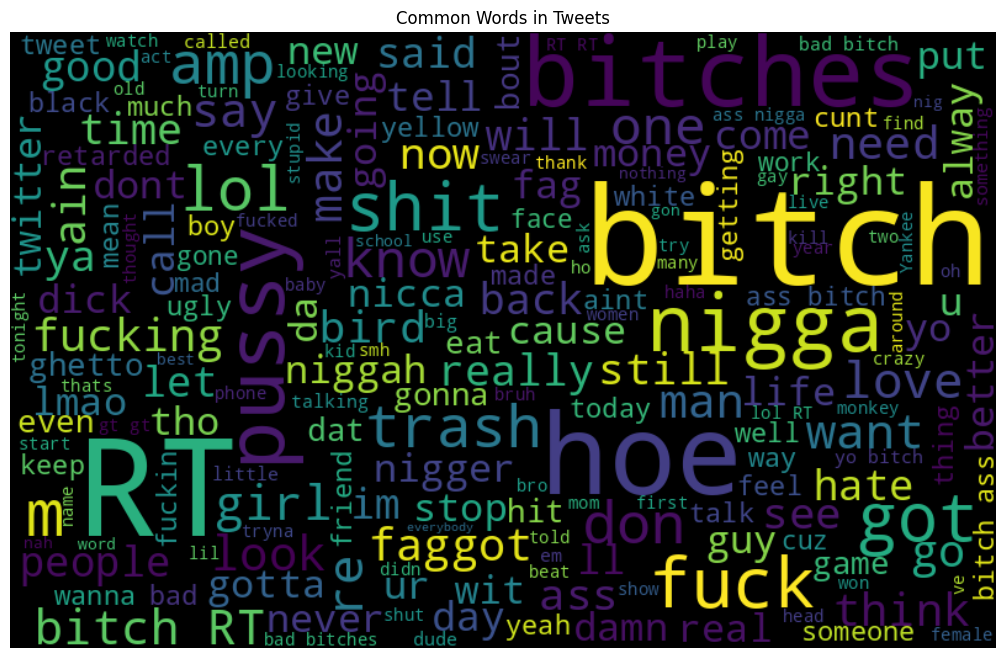

In [12]:
# word cloud - helps us to identify some most common words in the dataset
plot_wordcloud(df['clean_tweet'].tolist(), 'Common Words in Tweets')

# What we can infer from the word cloud?

**Prevalence of Offensive Terms:** The prominence of sure phrases indicates that derogatory and offensive phrases are often used in the dataset. These phrases are regularly related to hate speech and can be indicative of the varieties of language that algorithms want to discover and in all likelihood filter.

**Variety of Slurs:** A variety of slurs pertaining to race, sexual orientation, and gender appear in large fonts, indicating their unfortunate incidence inside the dataset. This reflects a need for sensitivity and precision in algorithms designed to hit upon and deal with such language.

**Common Swear Words:** Swear phrases are also distinctly seen within the word cloud, which shows that the dataset now not handiest carries language that is potentially hateful but also generally profane and vulgar. This underscores the undertaking of distinguishing among language this is truely offensive and language that crosses the line into hate speech.

**Social Media Markers:** The presence of "RT" (retweet) highlights that plenty of the textual content possibly originates from Twitter or similar social media structures where retweeting is not unusual. This contextual clue is critical for understanding the character of the conversation and the manner language is unfold on line.

**Contextual Usage:** While the word cloud shows the frequency of individual words, it would not provide facts approximately the context in which they may be used. Words that would appear impartial or maybe fantastic in a few contexts ("love," "existence," "woman," "boy") can take on different connotations relying on how they are used together with offensive or hateful language.

**Cultural References:** Some words may also have particular cultural references or be used particularly subcultures or groups. Understanding the cultural context may be crucial for the accurate classification of language.

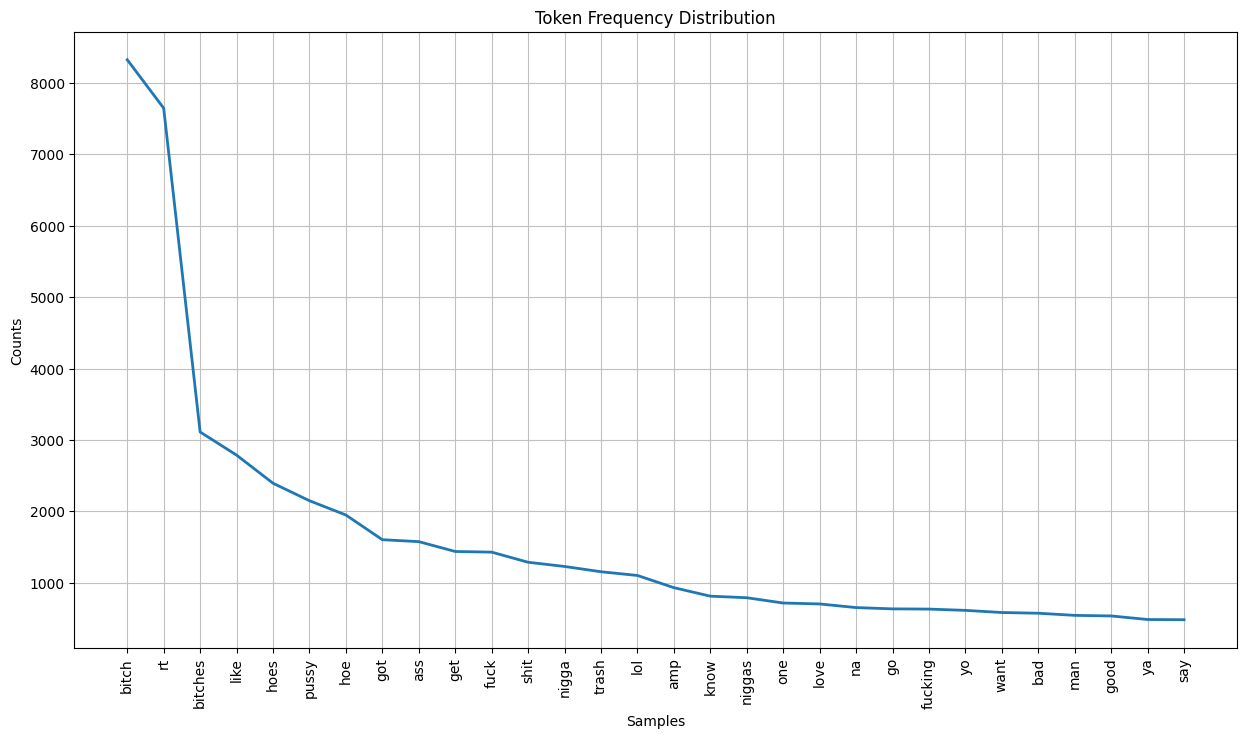

In [13]:
plot_frequency_distribution(df['tokens'], 'Token Frequency Distribution')

We can infer the following information from the Graph:

**Common offensive words:** The most frequently used tokens in the data set are clearly offensive words. The word "bitch" is the most important, followed by other derogatory words.

**Steep Drop-Off:** The number of words used after the first few words drops sharply, indicating that some words are used more often than others.

**Social media context:** Tokens such as "rt" (retweet) refer to data from social media platforms such as Twitter.

**Language diversity:** The presence of highly offensive words and neutral words such as "one", "love", and "good" indicates the diversity of languages ​​used in the data set

**Long-tail distribution:** After a sharp initial decrease, the curve becomes more flat, which is characteristic of a long-tail distribution This means that although some terms are used frequently, there are a number of terms that are rarely used does not work at all.

**Focus on formalism:** Common terminology emphasizes the need for robust resource management systems to recognize and process such language on social media platforms.

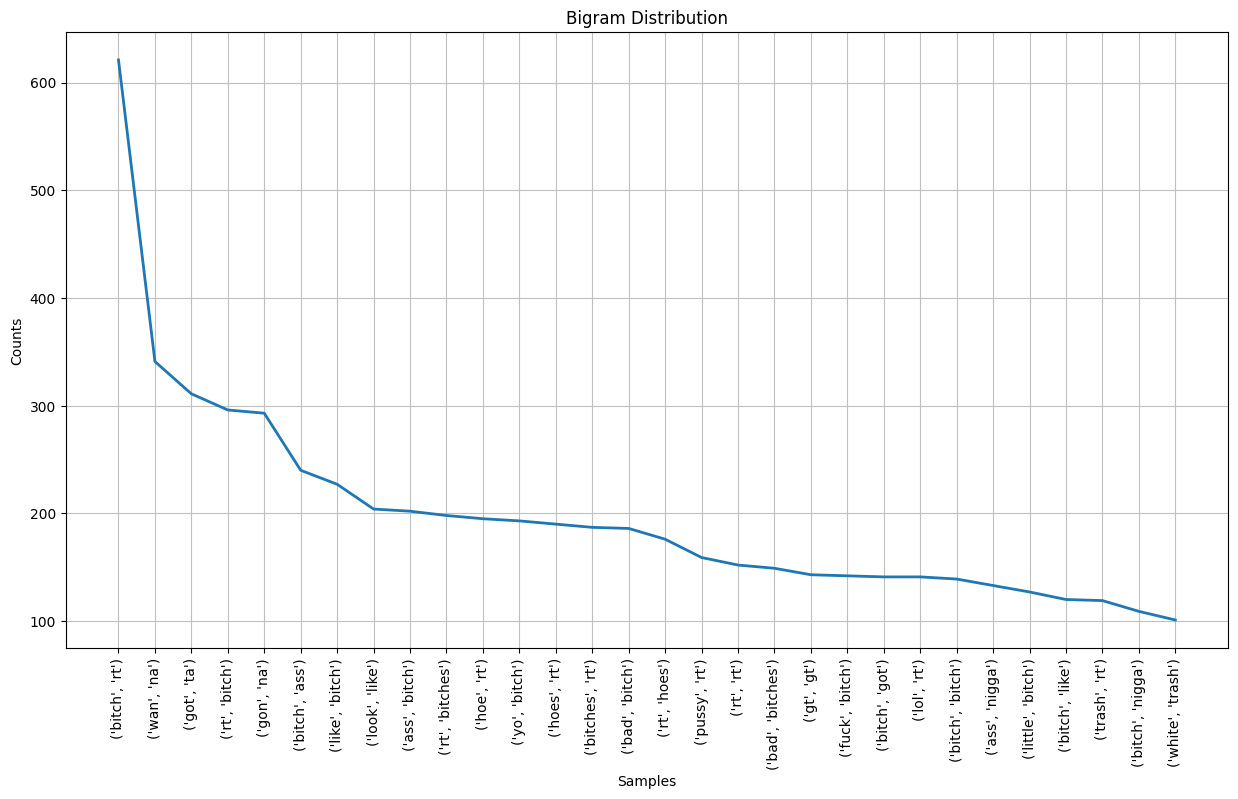

In [14]:
plot_ngrams_distribution(df['tokens'], n=2, title='Bigram Distribution')

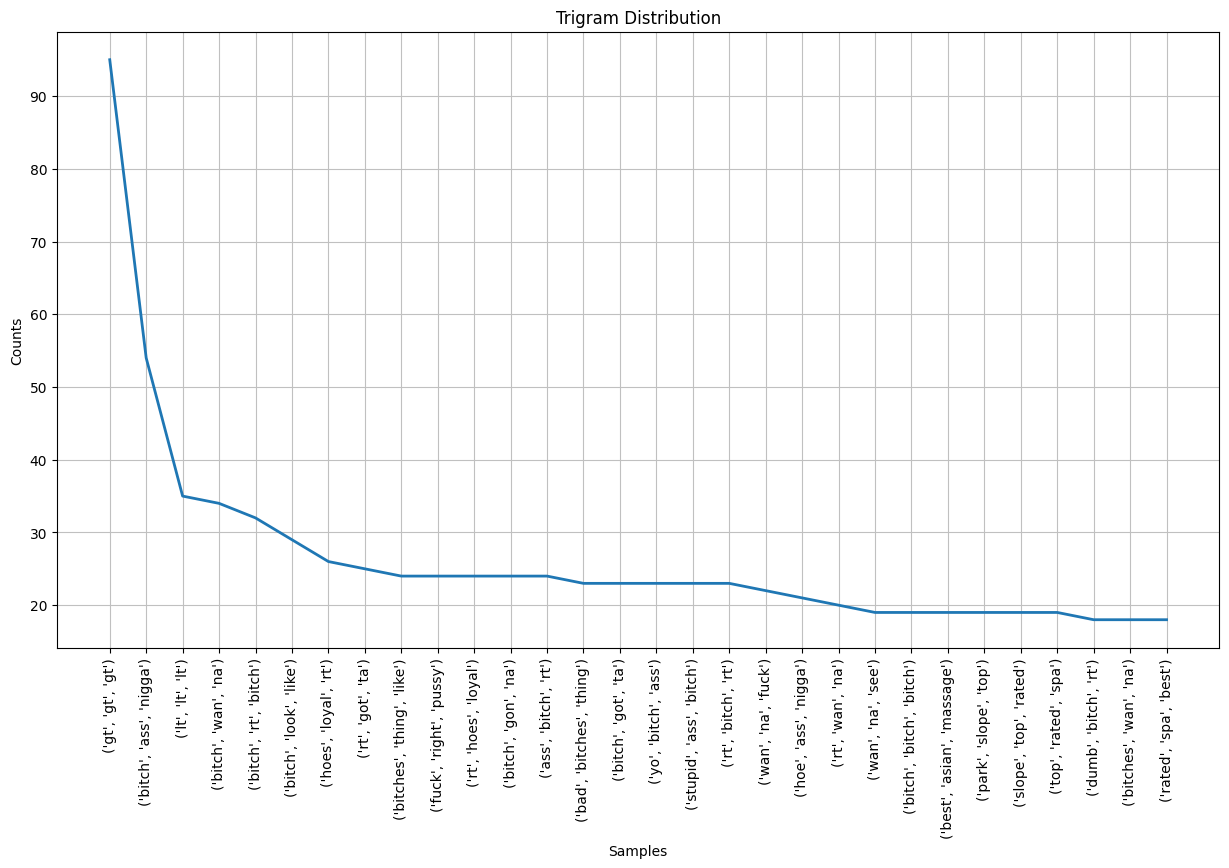

In [15]:
plot_ngrams_distribution(df['tokens'], n=3, title='Trigram Distribution')

# Comparing Bigrams and Trigrams we can infer the following information 

**Frequency:**
Bigrams is generally more common than trigrams. This is expected because the probability of two words appearing together is greater than the probability of three separate words appearing in succession.

**General terminology:**
Common bigrams and trigrams contain offensive and sarcastic language, indicating that these terms are frequently used together, possibly reflecting common words or phrases in the data set

**Difficult language:**
Trigrams show a complex linguistic structure, because they encompass a wider range of contexts than bigrams. The three most frequently used words include offensive words and other combinations of words, providing additional insight into how hate speech and offensive speech are structured in sentences

**Understanding context:**
Trigrams provide a clearer sense of context than bigrams. For example, while two words in a picture may indicate that together they are offensive, a trigram may reveal whether the sentence is part of a larger, more aggressive sentence or in a different context

**The distribution is steep:**
Both distributions show a sharp decline after the first few samples, but this decline is more pronounced in the trigrams. This suggests that typical three-word sentences are less diverse compared to two-word sentences, highlighting the unique combination of words that comprise hate speech and offensive speech

**Implications of physical self-control:**
The constant occurrence of offensive images and trigrams suggests that content-censorship systems must understand speech, not just individual words, to effectively identify and compress hate speech and offensive speech. 

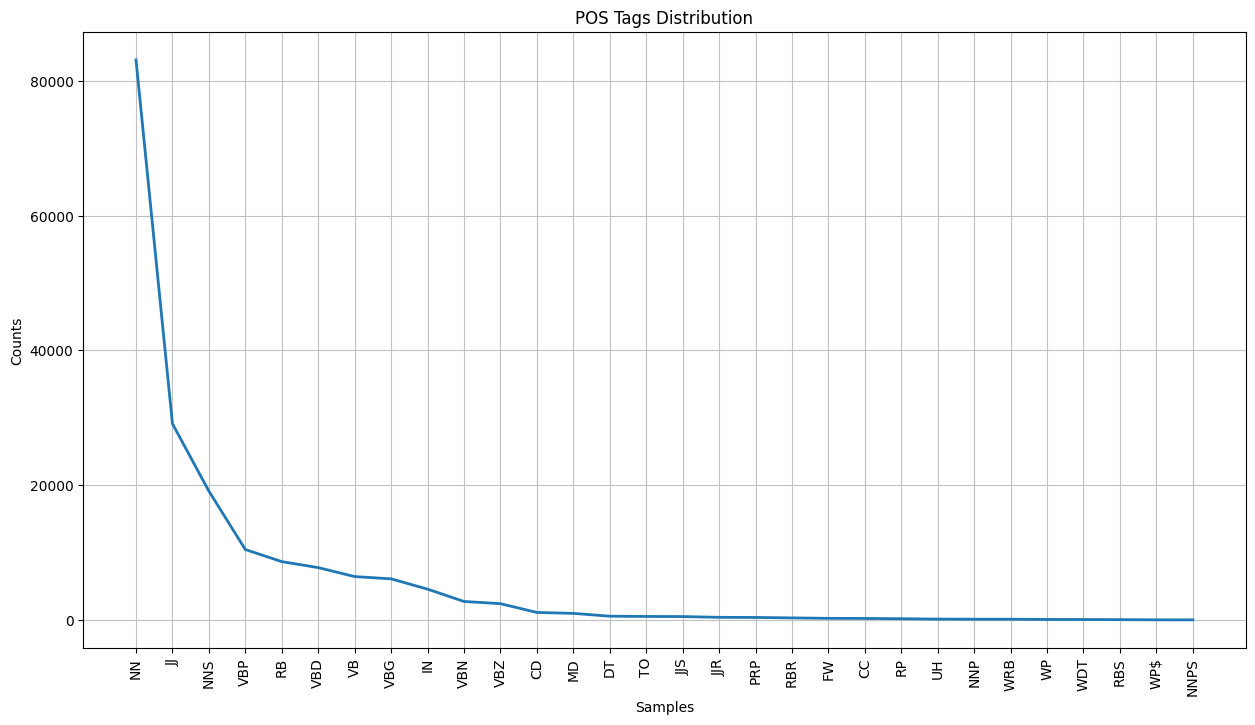

In [16]:
df['pos_tags'] = df['tokens'].apply(pos_tag)
plot_pos_distribution(df['pos_tags'], 'POS Tags Distribution')

We can infer the following information from the above graph

**Nouns Dominate:** The count of nouns (NN) is the highest, indicating that the dataset contains a significant amount of substantive content.

**Adjectives and Verbs:** Adjectives (JJ) and verbs in both singular (VB) and plural (VBP) forms also appear frequently, suggesting descriptive language and action-related content are common.

**Pronouns and Adverbs: **There's a moderate presence of pronouns (PRP) and adverbs (RB), which contribute to the narrative quality of the texts.

**Lower Frequency of Other Tags:** Tags representing conjunctions (CC), interjections (UH), and possessive endings (POS) have lower frequencies, which is typical in general language usage.

This POS tag distribution is useful for understanding the grammatical structure of the dataset and indicates the nature of the language that may need processing for tasks.

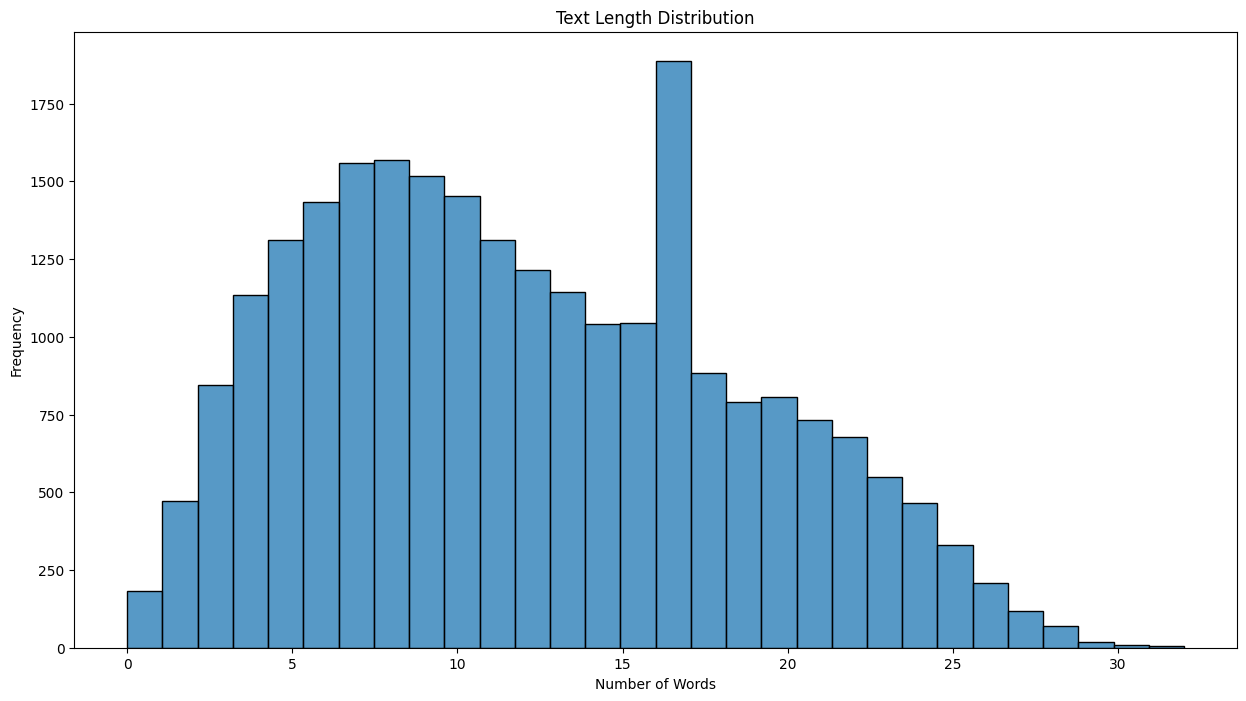

In [17]:
plot_text_length_distribution(df['clean_tweet'], 'Text Length Distribution')

we can infer the below information from the graph

**Modal Length:** The most common text length falls around 10-15 words, indicating a typical brevity in the dataset's entries.

**Short Texts:** There is a significant number of texts with very few words, which tail off as the text length increases.

**Longer Texts Less Common:** Texts over 20 words become increasingly rare, suggesting that the dataset primarily consists of concise statements.

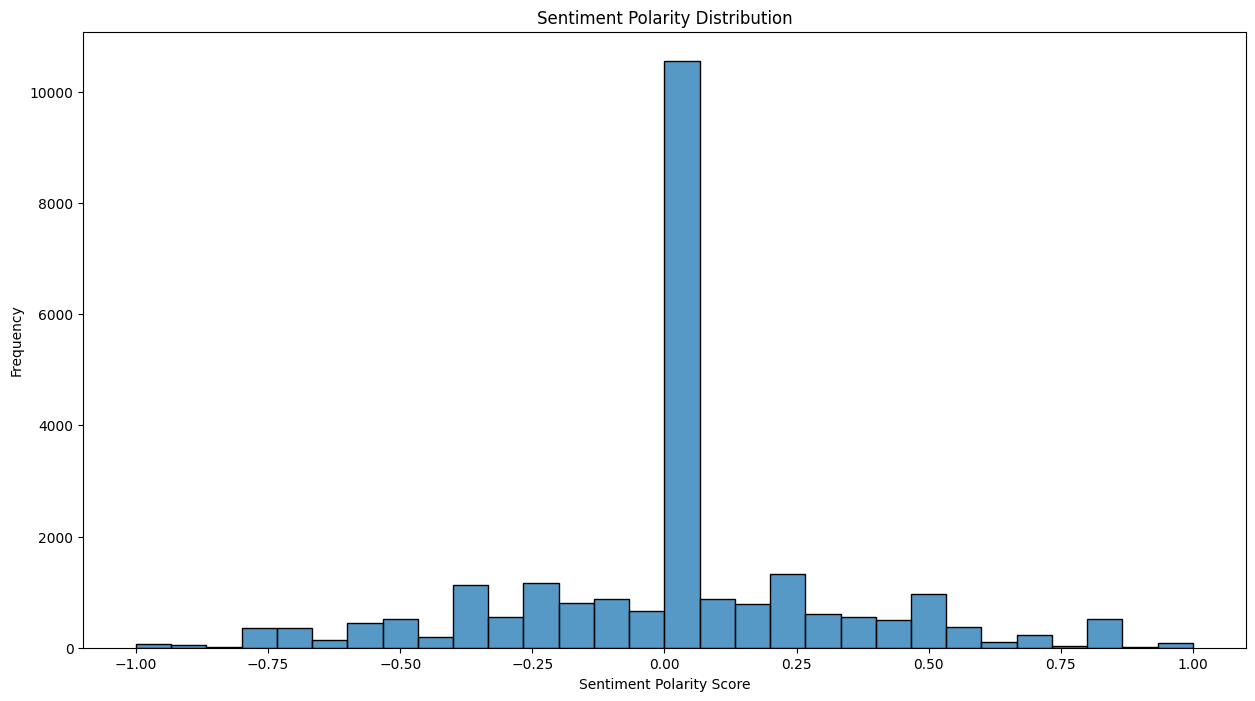

In [18]:
plot_sentiment_distribution(df['clean_tweet'], 'Sentiment Polarity Distribution')

**Neutral sentiment:** A long range at zero indicates that most text is classified as neutral, or that the sentiment analysis tool failed to identify a clear positive or negative sentiment.

**Emotion balance:** The distribution of emotion scores on both sides appears to be balanced, with equal frequencies of positive and negative emotions

**Minimal oversensitivity:** Few cases have strong negative or positive sensitivity (score close to -1 or +1), indicating that there is little oversensitivity in the dataset

**Sensitivity analysis difficulties:** A significant number of neutral scores may indicate the difficulty or ambiguity of sensitivity analysis in this context, especially when dealing with sarcasm, idioms, or specific language.

The classification suggests that although the data set may contain negative or positive emotions, the bulk of the transcripts may contain facts, a lack of strong emotional language, or mixed emotions an average from each side

# Training Data Preparation

In [19]:
X = df['clean_tweet'].values #features 
y = df['class'].values #target

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42) #splitting data to train and evaluate (80-20)

In [20]:
#cuda check for faster training on gpu compared to cpu
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


# Hyperparamter Optimization using Optuna


Optuna is an open-source hyperparameter optimization framework designed for gadget getting to know. It automates the system of locating the simplest hyperparameters for a given model and dataset, which can be a time-ingesting and complex mission whilst executed manually.

When using Optuna, the steps usually involve:

**Defining the Objective Function:** This is the function that Optuna will optimize. It ought to consist of the model training and evaluation system and go back the metric to optimize, like accuracy or loss. In this case like the code below, the objective characteristic takes the training and validation information, trains the version, evaluates it, and returns the evaluation accuracy.

**Wrapping the Objective Function:** The partial function from Python's functools is used to 'freeze' a few part of the goal characteristic's arguments (just like the dataset splits) even as permitting Optuna to adjust the hyperparameters.

**Creating a Study:** An Optuna study is an optimization session. The route parameter can be set to "maximize" or "minimize" depending on whether or not you need to boom the price of the objective characteristic (e.G., accuracy) or decrease it (e.G., loss).

**Optimizing the Study:** Optuna's study.Optimize() method takes the objective feature and the variety of trials to run. In each trial, Optuna suggests hyperparameters, runs the objective feature with the ones hyperparameters, and statistics the end result. The framework then makes use of those outcomes to suggest higher hyperparameters in subsequent trials.


In [21]:
# Wrap the objective function with partial to include dataset splits
objective_with_data = partial(objective, X_train=X_train, y_train=y_train, X_val=X_val, y_val=y_val)

# Create and optimize an Optuna study
study = optuna.create_study(direction="maximize")
study.optimize(objective_with_data, n_trials=3, gc_after_trial=True)

[I 2024-02-08 19:23:47,374] A new study created in memory with name: no-name-85256ff6-4c5a-490b-88d7-7fd5db3a2473
Some weights of DebertaForSequenceClassification were not initialized from the model checkpoint at microsoft/deberta-base and are newly initialized: ['classifier.bias', 'classifier.weight', 'pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
wandb: Currently logged in as: venkateshtantravahi99. Use `wandb login --relogin` to force relogin


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1 Score
1,0.383300,0.337568,0.877749,0.867349,0.877749,0.847813
2,0.266600,0.288692,0.906798,0.866377,0.906798,0.880249
3,0.218200,0.294939,0.907000,0.896875,0.907000,0.899985
4,0.182700,0.356291,0.902360,0.900771,0.902360,0.901534
5,0.111000,0.401236,0.905992,0.901305,0.905992,0.903334


[I 2024-02-08 19:56:19,666] Trial 0 finished with value: 0.9067984668146056 and parameters: {'num_train_epochs': 5, 'per_device_train_batch_size': 16, 'warmup_steps': 236, 'weight_decay': 0.04545116396486794}. Best is trial 0 with value: 0.9067984668146056.
Some weights of DebertaForSequenceClassification were not initialized from the model checkpoint at microsoft/deberta-base and are newly initialized: ['classifier.bias', 'classifier.weight', 'pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1 Score
1,0.392500,0.298156,0.902360,0.849374,0.902360,0.874518
2,0.265900,0.290367,0.906597,0.873583,0.906597,0.879848
3,0.213900,0.306490,0.906798,0.900136,0.906798,0.902595
4,0.175000,0.354813,0.900343,0.894741,0.900343,0.897187
5,0.107100,0.435295,0.902764,0.897325,0.902764,0.899663


[I 2024-02-08 20:28:20,548] Trial 1 finished with value: 0.9065967318942909 and parameters: {'num_train_epochs': 5, 'per_device_train_batch_size': 16, 'warmup_steps': 305, 'weight_decay': 0.04913272650667125}. Best is trial 0 with value: 0.9067984668146056.
Some weights of DebertaForSequenceClassification were not initialized from the model checkpoint at microsoft/deberta-base and are newly initialized: ['classifier.bias', 'classifier.weight', 'pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1 Score
1,No log,0.279501,0.902764,0.849554,0.902764,0.875155
2,0.353200,0.251984,0.910631,0.905028,0.910631,0.907310


[I 2024-02-08 20:39:29,292] Trial 2 finished with value: 0.910631430300585 and parameters: {'num_train_epochs': 2, 'per_device_train_batch_size': 32, 'warmup_steps': 258, 'weight_decay': 0.04428322937447672}. Best is trial 2 with value: 0.910631430300585.


In [22]:
# Output the best trial
print("Best trial:")
print(f"  Value: {study.best_trial.value}")
print("  Params: ")
for key, value in study.best_trial.params.items():
    print(f"    {key}: {value}")

Best trial:
  Value: 0.910631430300585
  Params: 
    num_train_epochs: 2
    per_device_train_batch_size: 32
    warmup_steps: 258
    weight_decay: 0.04428322937447672


# Training and Evaluating the model 

## Understanding DeBERTa and Its Advantages for Complex NLP Tasks

When dealing with advanced natural language processing (NLP) tasks such as hate speech detection, the choice of model architecture is critical. DeBERTa (Decoding-enhanced BERT with Disentangled Attention) offers significant improvements over regular Transformer-based models like BERT. It introduces a disentangled attention mechanism that processes content and position information separately, providing a finer understanding of the context within the text.

## Why Choose DeBERTa Over Regular Transformers

Traditional Transformer architectures, such as BERT, encode word and position information together, which can limit the model's ability to disentangle the nuances of language. DeBERTa addresses this by separating the embeddings, allowing for independent and more nuanced learning of content and positional context. This is particularly beneficial for tasks where the relative positioning of words significantly impacts their meaning, which is often the case in hate speech detection.

## DeBERTa's Innovations

DeBERTa improves upon the architecture of BERT in two main ways:

1. **Disentangled Attention Mechanism**: Unlike BERT, which uses a single embedding stream, DeBERTa separates the embeddings for word content and positional information. This allows DeBERTa to better capture the intricacies of language, improving its ability to understand context and nuance.

   ![Disentangled Attention Mechanism](https://miro.medium.com/v2/resize:fit:828/format:webp/1*n-oGkWfB8ZY-_VKLTYDSmQ.png)

2. **Enhanced Mask Decoder**: The enhanced mask decoder in DeBERTa uses the disentangled attention mechanism during pre-training. This improves the model's ability to handle dependencies between masked positions, a common challenge in many language models.

By leveraging these innovations, DeBERTa can achieve state-of-the-art performance on various NLP benchmarks.

## The Technical Details of DeBERTa

DeBERTa computes attention scores separately for content (the actual words) and relative position (the location of each word within a sequence). The attention score \( A_{ij} \) between two tokens \( i \) and \( j \) is calculated using both their content embeddings \( H \) and their relative position embeddings \( P \), according to the formula:

\[ A_{ij} = H_i^T W_q^T (H_j W_k + P_{ji} W_{k, rel}) + H_i^T W_{q, rel}^T (H_j W_k + P_{ji} W_{k, rel}) \]

where \( W_q \), \( W_k \), \( W_{q, rel} \), and \( W_{k, rel} \) are learnable parameters of the model.

The following images illustrate the components of DeBERTa's architecture and attention computation:

- **DeBERTa's Architecture**:

   ![DeBERTa Architecture](https://miro.medium.com/v2/resize:fit:828/format:webp/1*6PgadenApxx4vQ-YEu2Wcg.png)

- **Cross-Attention Computation btw two vectors in DeBERTa**:

   ![Cross-Attention Computation](https://miro.medium.com/v2/resize:fit:828/format:webp/1*xt8ceuK0eC62VRYF05q8tw.png)

- **Output disentangled attention calculation Embeddings**:

   ![Output disentangled attention matrix](https://miro.medium.com/v2/resize:fit:828/format:webp/1*kVUOXRjabo_HEckWDScaaA.png)

- **Relative position Calculation**:

   ![Relative Position](https://miro.medium.com/v2/resize:fit:828/format:webp/1*Yq18CRSMQhgp2h2cfCl_Sg.png)

In conclusion, DeBERTa's architectural choices make it an ideal candidate for complex NLP tasks, such as hate speech detection, where understanding the relative positions and content of words is essential. Its advanced attention mechanisms provide a more refined analysis of language, leading to better model performance and more accurate outcomes.


In [23]:
# Tokenizer and model initialization
tokenizer = DebertaTokenizer.from_pretrained("microsoft/deberta-base")
model = DebertaForSequenceClassification.from_pretrained("microsoft/deberta-base", num_labels=np.unique(y_train).size).to(device)

# Dataset preparation
train_dataset = DebertaDataset(tokenizer, X_train.tolist(), y_train, max_length=128)
val_dataset = DebertaDataset(tokenizer, X_val.tolist(), y_val, max_length=128)

# Training arguments with Optuna trial suggestions
training_args = TrainingArguments(
    output_dir='./model_train_results',
    num_train_epochs=8,
    per_device_train_batch_size= study.best_trial.params['per_device_train_batch_size'],
    fp16 = torch.cuda.is_available(), # Enable mixed precision if CUDA is available
    warmup_steps= 258,
    weight_decay= 0.04428322937447672,
    evaluation_strategy="epoch",  # Evaluate at the end of each epoch
    save_strategy="epoch",  # Ensure this matches the evaluation strategy
    logging_dir='./logs',
    load_best_model_at_end=True  # Load the best model at the end of training
)

# Initialize Trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    compute_metrics=compute_metrics  # Define this function as shown before
)

# Train and evaluate
trainer.train()

# Evaluate the model
results = trainer.evaluate()

print(results)

Some weights of DebertaForSequenceClassification were not initialized from the model checkpoint at microsoft/deberta-base and are newly initialized: ['classifier.bias', 'classifier.weight', 'pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1 Score
1,No log,0.275083,0.897115,0.888538,0.897115,0.872929
2,0.344300,0.260462,0.910833,0.893576,0.910833,0.892575
3,0.344300,0.267629,0.904781,0.901831,0.904781,0.903048
4,0.190900,0.313857,0.897720,0.905550,0.897720,0.901083
5,0.119200,0.390893,0.898326,0.898234,0.898326,0.898280
6,0.119200,0.428695,0.898326,0.888693,0.898326,0.892485
7,0.061200,0.661317,0.898729,0.897298,0.898729,0.897930
8,0.061200,0.855400,0.901553,0.895382,0.901553,0.898052


{'eval_loss': 0.26046210527420044, 'eval_accuracy': 0.9108331652208997, 'eval_precision': 0.8935760674387624, 'eval_recall': 0.9108331652208997, 'eval_f1_score': 0.8925749010174354, 'eval_runtime': 38.0096, 'eval_samples_per_second': 130.414, 'eval_steps_per_second': 8.156, 'epoch': 8.0}


# Understanding the Predictions or Metrics Evaluated on

In [24]:
results

{'eval_loss': 0.26046210527420044,
 'eval_accuracy': 0.9108331652208997,
 'eval_precision': 0.8935760674387624,
 'eval_recall': 0.9108331652208997,
 'eval_f1_score': 0.8925749010174354,
 'eval_runtime': 38.0096,
 'eval_samples_per_second': 130.414,
 'eval_steps_per_second': 8.156,
 'epoch': 8.0}

Analyzing the results after training the model using DeBERTa, we can draw several conclusions and create a narrative around the model's performance:

**Overall Performance:**
The model achieved a high evaluation accuracy of 91.08%, indicating that it was able to correctly predict the label for a large majority of the samples in the evaluation dataset.

**Evaluation Loss:**
With an evaluation loss of 0.2605, the model shows a good fit to the data, suggesting that the predictions are reliable and the model is not underfitting or overfitting significantly.

**Precision and Recall:**
The model's precision (89.36%) and recall (91.08%) are quite balanced, which is desirable in a classification task. A balanced precision and recall suggest that the model is not overly biased towards false positives or false negatives.

**F1 Score:**
The F1 score, which is the harmonic mean of precision and recall, stands at 89.26%. This further confirms the model's balanced performance between precision and recall.

**Inference Time:**
The model's evaluation runtime and the number of samples it can process per second indicate it is relatively efficient, which is an important consideration for deploying the model in a real-world application.

In [26]:
predictions = trainer.predict(val_dataset)
y_pred = np.argmax(predictions.predictions, axis=1)
y_true = predictions.label_ids

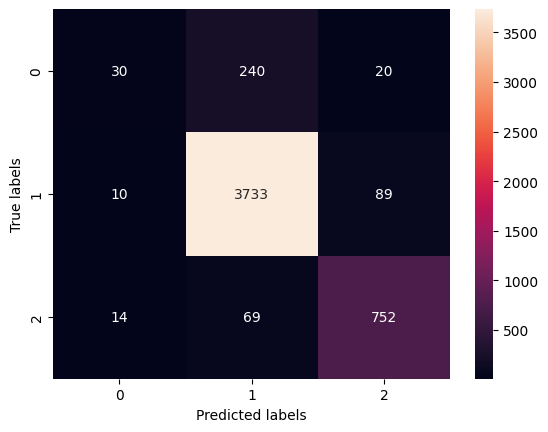

In [27]:
conf_matrix = confusion_matrix(y_true, y_pred)
sns.heatmap(conf_matrix, annot=True, fmt='g')
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.show()

The confusion matrix shows that the model is quite adept at identifying the most frequent class (label 1). However, there is some confusion between the less frequent classes (labels 0 and 2). This suggests that while the model is strong, there could be room for improvement, particularly in distinguishing between these less represented classes.

{"epoch": [1, 2, 3, 4, 5, 6, 7, 8], "training_loss": [null, 0.3443, 0.3443, 0.1909, 0.1192, 0.1192, 0.0612, 0.0612], "validation_loss": [0.275083, 0.260462, 0.267629, 0.313857, 0.390893, 0.428695, 0.661317, 0.8554], "accuracy": [0.897115, 0.910833, 0.904781, 0.89772, 0.898326, 0.898326, 0.898729, 0.901553], "precision": [0.888538, 0.893576, 0.901831, 0.90555, 0.898234, 0.888693, 0.897298, 0.895382], "recall": [0.897115, 0.910833, 0.904781, 0.89772, 0.898326, 0.898326, 0.898729, 0.901553], "f1_score": [0.872929, 0.892575, 0.903048, 0.901083, 0.89828, 0.892485, 0.89793, 0.898052]}


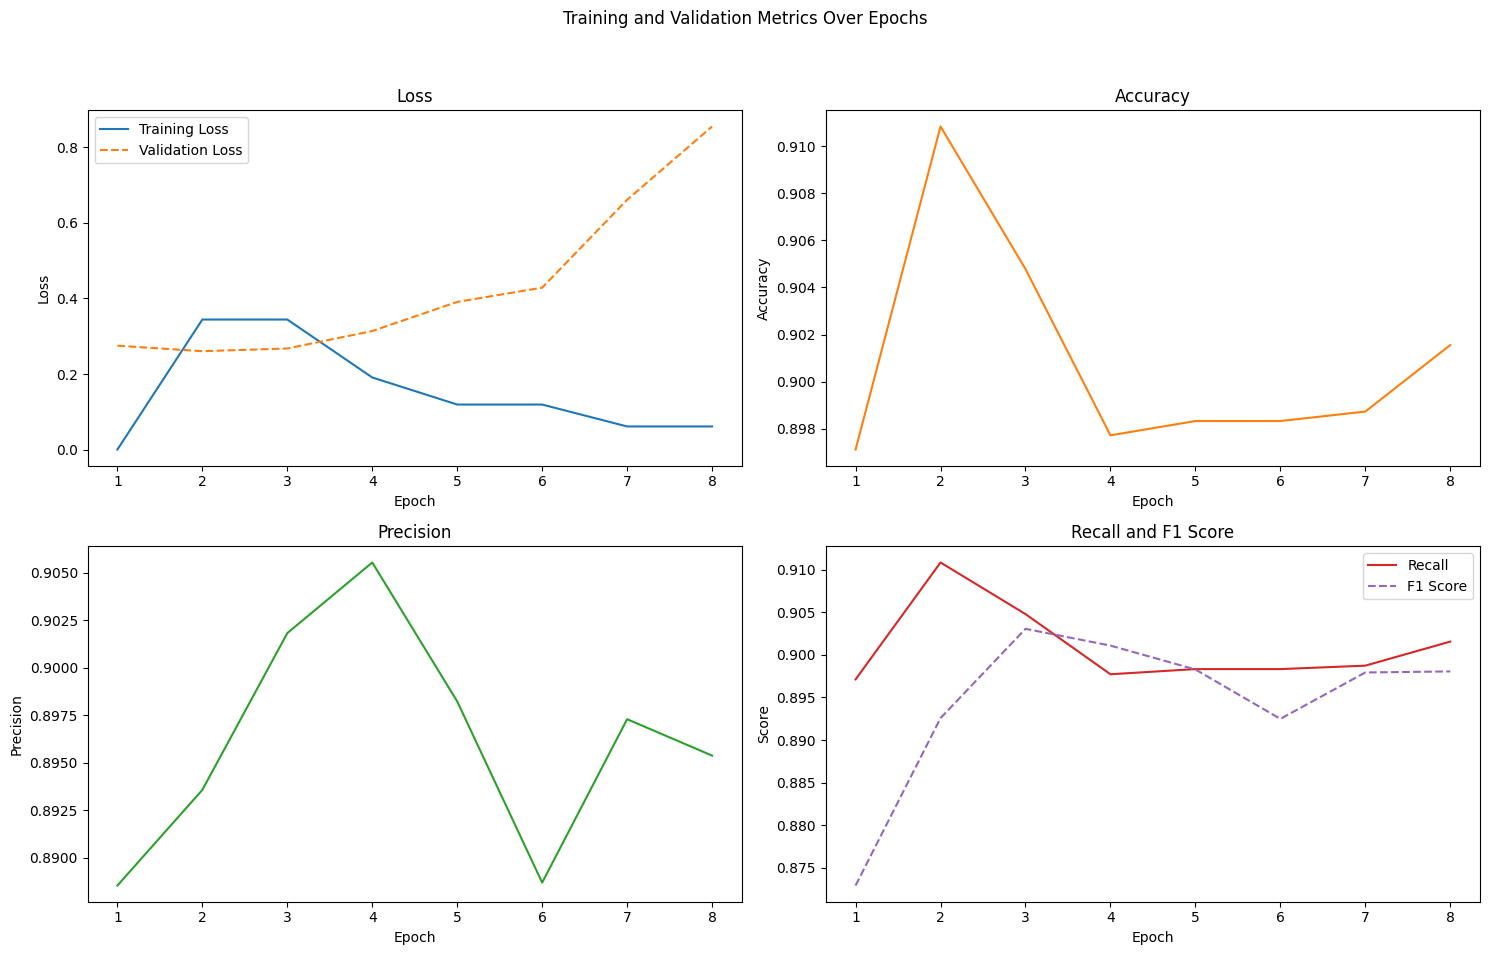

In [31]:
import json
import matplotlib.pyplot as plt

# Data provided for epochs, training loss, validation loss, accuracy, precision, recall, F1 score
data = {
    "epoch": [1, 2, 3, 4, 5, 6, 7, 8],
    "training_loss": [None, 0.3443, 0.3443, 0.1909, 0.1192, 0.1192, 0.0612, 0.0612],
    "validation_loss": [0.275083, 0.260462, 0.267629, 0.313857, 0.390893, 0.428695, 0.661317, 0.855400],
    "accuracy": [0.897115, 0.910833, 0.904781, 0.897720, 0.898326, 0.898326, 0.898729, 0.901553],
    "precision": [0.888538, 0.893576, 0.901831, 0.905550, 0.898234, 0.888693, 0.897298, 0.895382],
    "recall": [0.897115, 0.910833, 0.904781, 0.897720, 0.898326, 0.898326, 0.898729, 0.901553],
    "f1_score": [0.872929, 0.892575, 0.903048, 0.901083, 0.898280, 0.892485, 0.897930, 0.898052]
}

# Convert to JSON
json_data = json.dumps(data)
print(json_data)

# Plotting
fig, axs = plt.subplots(2, 2, figsize=(15, 10))
fig.suptitle('Training and Validation Metrics Over Epochs')

# Handling None values for plotting
data["training_loss"] = [0 if v is None else v for v in data["training_loss"]]

# Training and Validation Loss
axs[0, 0].plot(data["epoch"], data["training_loss"], label='Training Loss')
axs[0, 0].plot(data["epoch"], data["validation_loss"], label='Validation Loss', linestyle='--')
axs[0, 0].set_title('Loss')
axs[0, 0].set_xlabel('Epoch')
axs[0, 0].set_ylabel('Loss')
axs[0, 0].legend()

# Accuracy
axs[0, 1].plot(data["epoch"], data["accuracy"], label='Accuracy', color='tab:orange')
axs[0, 1].set_title('Accuracy')
axs[0, 1].set_xlabel('Epoch')
axs[0, 1].set_ylabel('Accuracy')

# Precision
axs[1, 0].plot(data["epoch"], data["precision"], label='Precision', color='tab:green')
axs[1, 0].set_title('Precision')
axs[1, 0].set_xlabel('Epoch')
axs[1, 0].set_ylabel('Precision')

# Recall and F1 Score
axs[1, 1].plot(data["epoch"], data["recall"], label='Recall', color='tab:red')
axs[1, 1].plot(data["epoch"], data["f1_score"], label='F1 Score', color='tab:purple', linestyle='--')
axs[1, 1].set_title('Recall and F1 Score')
axs[1, 1].set_xlabel('Epoch')
axs[1, 1].set_ylabel('Score')
axs[1, 1].legend()

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

- The loss graph shows that while training loss decreases, validation loss increases slightly over time, indicating potential overfitting past a certain epoch.
- The accuracy graph has a peak at the beginning, which could suggest an initial overfitting that the model later corrects.
- Precision and recall fluctuations imply that the model's ability to consistently identify true positives and relevant samples varies from epoch to epoch, which could be a point of further optimization.